In [1]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
classes=('penis','vagina','breast','butt','naked-body','naked-bottom','underwear','bra','hand','dildo','cum','tongue')
classes=('penis','vagina','breast','butt','naked-body','naked-bottom','underwear','bra','dildo','cum')


In [2]:

## config_file = '../configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
config_file = '../configs/censor/faster_rcnn_x101_32x4d_fpn_1x_censor.py'
config_file = '../configs/censor/faster_rcnn_x101_32x4d_fpn_1x_censor-freeze-s1-coloraug.py'
config_file = '../configs/censor/faster_rcnn_x101_32x4d_fpn_1x_censor-freeze-s1.py'
# download the checkpoint from model zoo and put it in `checkpoints/`
#checkpoint_file = '../checkpoints/faster_rcnn_r50_fpn_1x_20181010-3d1b3351.pth'
checkpoint_file = '../work_dirs/faster_rcnn_x101_32x4d_fpn_1x_censor/epoch_17.pth'
checkpoint_file = '../work_dirs/faster_rcnn_x101_32x4d_fpn_1x_censor-rot/epoch_29.pth'
checkpoint_file = '../work_dirs/faster_rcnn_x101_32x4d_fpn_1x_censor-freeze-s1-coloraug/epoch_25.pth'
checkpoint_file = '../work_dirs/faster_rcnn_x101_32x4d_fpn_1x_censor-freeze-s1/epoch_20.pth'
#checkpoint_file = '../work_dirs/faster_rcnn_x101_32x4d_fpn_1x_censor-freeze-s4/epoch_48.pth'
#checkpoint_file = '../work_dirs/faster_rcnn_x101_32x4d_fpn_1x_censor/epoch_20.pth'

config_file = '../configs/censor/faster_rcnn_x101_32x4d_fpn_1x_censor-freeze-s1.py'
checkpoint_file = '../work_dirs/faster_rcnn_x101_32x4d_fpn_1x_censor-freeze-s1/epoch_38.pth'
checkpoint_file = '../work_dirs/class12/faster_rcnn_x101_32x4d_fpn_1x_censor-freeze-s1/epoch_34.pth'
checkpoint_file = '../work_dirs/faster_rcnn_x101_32x4d_fpn_1x_censor-freeze-s1/epoch_27.pth'
checkpoint_file = '../pretrained/censor/faster_rcnn_x101_32x4d_fpn_1x_rotdat-epoch10.pth'
model = init_detector(config_file, checkpoint_file, device='cuda:1')

two_stage.py: pretrained=  None


In [46]:
# build the model from a config file and a checkpoint file

lines = open('/home/jovyan/fast-data/tusou_test/script/valid.lst','r').readlines()
PORN6=['hentai','anime','norm','porn','sexy','very_sexy']
dat={}
print(len(lines))
for line in lines:
    a = line.rstrip().split(' ')
    file = a[0]
    annt = PORN6[int(a[1])]
    if annt not in dat.keys():
        dat[annt]=[]
        dat[annt].append(file)
    else:
        dat[annt].append(file)
#print(dat)
test_data= dat
print(test_data.keys())

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/fast-data/tusou_test/script/valid.lst'

In [3]:
import cv2
import os
import json
#lines = open('../data/censor/test/abby_fc2_test.txt').readlines()
#lines = open('../data/censor/test/fc2_photos.txt').readlines()
# lines = open('/home/shengtao/Data/tusou_test/tusou_1.txt').readlines()
# test_data={}
# for line in lines:
#     img_path = line.rstrip('\n')
#     img_tag = img_path.split('/')[-2]
#     if img_tag  not in test_data.keys():
#         test_data[img_tag]=[img_path]
#     else:
#         test_data[img_tag].append(img_path)
# print(test_data.keys())
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm

def get_test_data(fpath):
    lines = open(fpath).readlines()
    test_data={}
    for line in lines:
        img_path = line.rstrip('\n')
        img_tag = img_path.split('/')[-2]
        if img_tag  not in test_data.keys():
            test_data[img_tag]=[img_path]
        else:
            test_data[img_tag].append(img_path)
    print(test_data.keys())
    return test_data

def check_result(result,thr):
    checkList = [0,1,2,3,4,5,6,7,9,10,11] # without hand
    for i in checkList:
        if result[i].shape[0]>0:
            for j in range(result[i].shape[0]):
                if result[i][j,4]>=thr:
                    return True
    return False

def draw_rects(imageFile,ret,thre=0.3, classes_name=''):
    #print(len(ret))
    if classes_name == '':
        classes=( 'penis', 'vagina','breast', 'butt','naked-body', 'naked-bottom', 'underwear','bra','hand','dildo','cum','tongue')
    else:
        classes = classes_name
    #print(len(classes))
    img = cv2.imread(imageFile)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #bb = an['bbox']
    for i in range(12):
        #print(ret[i])
        if ret[i].shape[0] == 0:
            continue
        else:
            for j in range(ret[i].shape[0]):
                
                bb = ret[i][j,:]
                #print(bb)
                pt1= (int(bb[0]),int(bb[1]))
                pt2=(int(bb[2]), int(bb[3]))
                conf = bb[4]
                if conf <thre:
                    continue
                img=cv2.rectangle(img,pt1,pt2,(255,0,0),3)
                img=cv2.putText(img,classes[i]+' | %.2f'%conf,pt1, cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,255),2,cv2.LINE_AA)
    #print('done')
    return img
def test_list(model,fpath, saveRoot='/home/shengtao/Data/coco/ret/',thr=0.3, saveAllPos=False,saveAllNeg=False):
    if not os.path.exists(saveRoot):
        os.mkdir(saveRoot)
    test_data = get_test_data(fpath)
    testKeys = list(test_data.keys())
    fid = open('./'+fpath.split('/')[-1]+'_ret.json','w')
    retDat = {}

    for tag in tqdm(testKeys):
        #count = count+1
        if tag not in retDat.keys():
            retDat[tag]={}
        #for imgfile in tqdm(test_data[tag]):
        for imgfile in test_data[tag]:    
            try:
                result = inference_detector(model, imgfile)
                ret = check_result(result,thr)
                cat = imgfile.split('/')[-2]
                if saveAllPos:
                    if ret:
                        img = draw_rects(imgfile,result,thr,classes_name=classes)
                        cv2.imwrite(saveRoot+'%d_'%ret+cat+'_'+imgfile.split('/')[-1].split('.')[0]+'.jpg',img)  
                if saveAllNeg:
                    if not ret:
                        img = draw_rects(imgfile,result,thr,classes_name=classes)
                        cv2.imwrite(saveRoot+'%d_'%ret+cat+'_'+imgfile.split('/')[-1].split('.')[0]+'.jpg',img)                          
                retDat[tag][imgfile]={}
                for ij in range(10):
                    #print(result[ij])
                    crtClass = classes[ij]
                    retDat[tag][imgfile][crtClass]=[]
                    for ix in range(result[ij].shape[0]):
                        #retDat[tag][imgfile][crtClass].append(list(result[ij][ix]))
                        crtRet=result[ij][ix].tolist()
                        retDat[tag][imgfile][crtClass].append(crtRet)
            except:
                print(imgfile+' failed')
                retDat[tag][imgfile]={}
                #fid.write(imgfile+' 0\n')
                continue
    #print(retDat)            
    json.dump(retDat,fid,indent=4)
    fid.close()
    return retDat
#test_list(model,'/home/shengtao/Data/tusou_test/fc2_failed_photo.txt')
#saveRoot = '/home/shengtao/Data/tusou_test/tusou_3_ret/'
#retDat = test_list(model,'/home/shengtao/Data/tusou_test/tusou_3.txt',saveRoot,thr=0.5,saveAllPos=True,saveAllNeg=True)
#test_list(model,'/home/shengtao/Data/coco/coco.txt')
#testFile = '/home/shengtao/Data/censor_dat/test/fc2_videos/fc2_video_2012.txt'
#retDat = test_list(model,testFile,saveRoot='./',thr=0.5,saveAllPos=False,saveAllNeg=False)
# testFile = '/home/shengtao/Data/censor_dat/test/fc2_videos/fc2_video_2013.txt'
# retDat = test_list(model,testFile,saveRoot='./',thr=0.5,saveAllPos=False,saveAllNeg=False)
#testFile = '/home/shengtao/Data/censor_dat/test/fc2_videos/fc2_video_2014.txt'
#retDat = test_list(model,testFile,saveRoot='./',thr=0.5,saveAllPos=False,saveAllNeg=False)
# testFile = '/home/shengtao/Data/censor_dat/test/fc2_videos/fc2_video_2015.txt'
# retDat = test_list(model,testFile,saveRoot='./',thr=0.5,saveAllPos=False,saveAllNeg=False)
#testFile = '/home/shengtao/Data/censor_dat/test/fc2_videos/fc2_video_2017.txt'
#retDat = test_list(model,testFile,saveRoot='./',thr=0.5,saveAllPos=False,saveAllNeg=False)
# testFile = '/home/shengtao/Data/censor_dat/test/fc2_videos/fc2_video_2018.txt'
# retDat = test_list(model,testFile,saveRoot='./',thr=0.5,saveAllPos=False,saveAllNeg=False)
testFile = '/home/jovyan/fast-data/porn_sel.txt'
retDat = test_list(model,testFile,saveRoot='./',thr=0.4,saveAllPos=False,saveAllNeg=False)


  0%|          | 0/1 [00:00<?, ?it/s]

dict_keys(['porn_sel'])
/home/jovyan/fast-data/porn_sel/t0155d31a4ef47df948_ali_block_porn_98.0.jpg failed
/home/jovyan/fast-data/porn_sel/t01cd3b3ec771a40758_ali_pass_normal_99.9.jpg failed
/home/jovyan/fast-data/porn_sel/t019748af0006f33f18_ali_pass_normal_99.9.jpg failed
/home/jovyan/fast-data/porn_sel/t01c8397ddfabf0bcdd_ali_pass_normal_99.9.jpg failed
/home/jovyan/fast-data/porn_sel/t013e0a113178df5d26_ali_pass_normal_99.9.jpg failed
/home/jovyan/fast-data/porn_sel/t01c95ce0ca59c9d06c_ali_pass_normal_99.9.jpg failed
/home/jovyan/fast-data/porn_sel/t0182d6559032445ab1_ali_review_sexy_82.6.jpg failed
/home/jovyan/fast-data/porn_sel/t0132a20de8f2a20855_ali_review_sexy_93.8.webp failed
/home/jovyan/fast-data/porn_sel/t01337dd6252f87e5c2_ali_review_sexy_98.4.jpg failed
/home/jovyan/fast-data/porn_sel/t01b53271f46cb13c15_ali_review_porn_73.9.jpg failed


100%|██████████| 1/1 [1:05:22<00:00, 3922.03s/it]


In [63]:
import random
import shutil
def move_sel_test_to_train(test_data):
    tags=['Wet_pussy','Anus_asshole','Cream_pie','Meaty_lips','Anal_dildo','Clitoris_close_up','Dildo_in_pussy','Fingering','Fisting','Blowjob','Hairy_pussy_close_up','Natural_hairy_bush','Nip_slip','Nipple_to_nipple','Pee_porn','Shot_from_below','Wet_pussy']
    dats=[]
    for tag in tags:
        print(tag, len(test_data[tag]))
        random.shuffle(test_data[tag])
        dats = dats+test_data[tag][:int(len(test_data[tag])*0.2)]
    random.shuffle(dats)
    print(len(dats))
    for img in dats[:500]:
        newPath = '/home/shengtao/Data/censor_dat/test/abby_train/'+img.split('/')[-1]
        print(img,newPath)
        shutil.copyfile(img,newPath)
        
#move_sel_test_to_train(test_data)
print(0)

0


/home/shengtao/Data/censor_dat/test/abbywinter/Meaty_lips/candice250-med.jpg


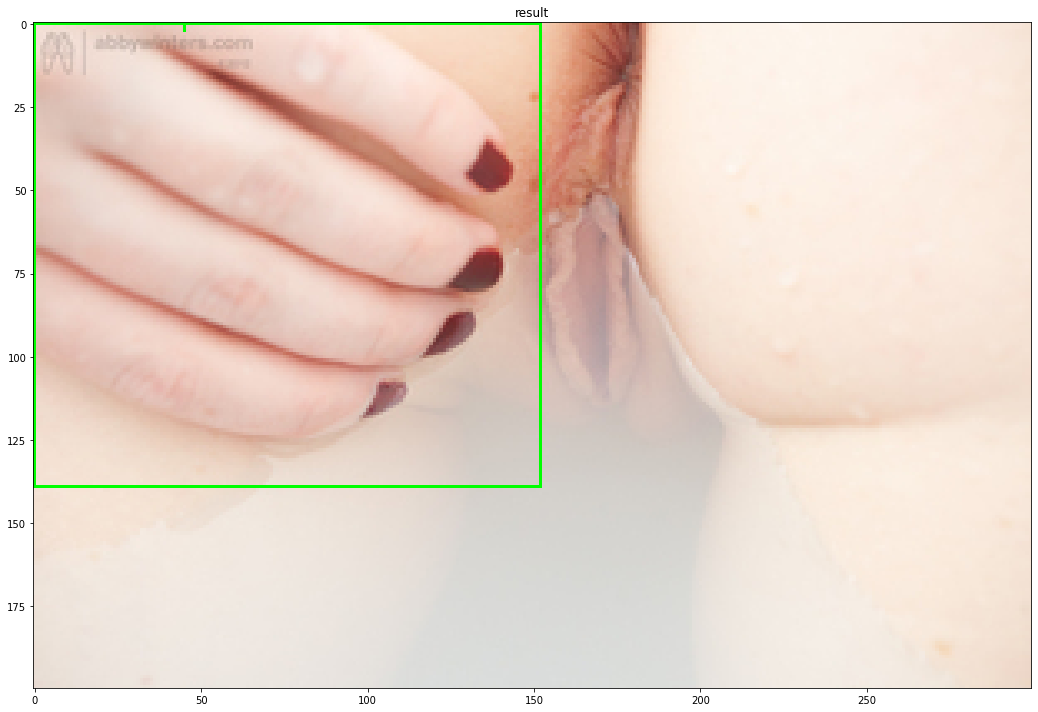

In [27]:
# test a single image
import cv2
img = 'demo.jpg'
img = '/home/jovyan/fast-data/tusou_test/porn/(m=bJ4hdaaecaa)(mh=-EDlnUGRnKxMCZ-J)original_208989461.jpg'
for imgfil in test_data['Meaty_lips'][:100]:
    img_bgr = cv2.imread(imgfil)
    #print(imgfil)
    img_rgb=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    #result = inference_detector(model, img_bgr)
    result = inference_detector(model, imgfil)
    if not check_result(result):
    #print(result)
        print(imgfil)
        show_result_pyplot(model, imgfil, result,score_thr=0.3)

In [6]:
import cv2
img = 'demo.jpg'
img = '/home/jovyan/fast-data/tusou_test/porn/(m=bJ4hdaaecaa)(mh=-EDlnUGRnKxMCZ-J)original_208989461.jpg'
imgList = []
count = 0
testKeys = list(test_data.keys())
for tag in testKeys:
    #tag = 'Meaty_lips'
    for imgfile in test_data[tag]:
        count = count+1
        #img_bgr = cv2.imread(imgfil)
        #img_rgb=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        try:
            result = inference_detector(model, imgfile)
        except:
            continue
        if not check_result(result):
            print(imgfile)
            imgList.append(imgfile)
print(count, len(imgList))
fid = open('./test_failed_fc2_photos.txt','w')
for x in imgList:
    fid.write(x+'\n')
fid.close()

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/864351/1529740052.85.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/864351/1529740051.89.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/864351/1529740050.32.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/860630/1529353491.72.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/950652/1539147271.51.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/934791/1537410527.92.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/934791/1537410527.67.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/928963/1536843848.08.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/898398/1533559306.24.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/898398/1533559306.49.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/898398/1533559306.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/898398/1

In [41]:
import cv2
img = 'demo.jpg'
img = '/home/jovyan/fast-data/tusou_test/porn/(m=bJ4hdaaecaa)(mh=-EDlnUGRnKxMCZ-J)original_208989461.jpg'
imgList = []
count = 0
testKeys = list(test_data.keys())
tag = 'javporn'

for imgfile in test_data[tag]:
    count = count+1
    #img_bgr = cv2.imread(imgfil)
    #img_rgb=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    result = inference_detector(model, imgfile)
    if not check_result(result):
        #print(imgfile)
        imgList.append(imgfile)
print(count, len(imgList))
fid = open('./test_failed_javporn.txt','w')
for x in imgList:
    fid.write(x+'\n')
fid.close()

5191 408


In [36]:
print(len(imgList))

548


In [7]:
import shutil 
for x in imgList:
    shutil.copyfile(x,'./test_failed_fc2Photos/'+x.split('/')[-2]+'_'+x.split('/')[-1])